[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/SURIAPRAKASH1/hard2train_GANs/blob/main/notebooks/colab_gans.ipynb)

In [ ]:
# packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import v2

import numpy as np
import cv2
from moviepy.editor import ImageSequenceClip
from IPython.display import Video

import matplotlib.pyplot as plt
from PIL import Image

import time
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("current device ->" ,device)

  if event.key is 'enter':



current device -> cpu


**Preprocessing Dataset**

In [ ]:
class CustomNormalizer(nn.Module):
    """
    CustomNormalizer to normalize image pixels to within range of (-1, 1) according to paper.
    cause we are using tanh in Generator Model at last layer
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        C, H, W = x.shape       # (channels, height, width)

        # if grey scale image then we have to make it have 3 pixels
        # only i did this way so we can use model same architecture as proposed in paper for mnist dataset too
        if C < 3:
            x = torch.repeat_interleave(x, dim = 0, repeats = 3)

        x = (x / 255) * 2 - 1      # normalizer to (-1, 1) range
        return x


transform = v2.Compose([
    v2.ToImage(),                            # converts Image to tensor
    v2.Resize((64, 64), antialias= True),    # Resizeing . (v2.Resize() only work with tensor correctly)
    v2.ToDtype(dtype= torch.float32),        # make sure
    CustomNormalizer(),                      # custom normalizer do's some transformation
])


# Dataset
mnist_root = "<http://yann.lecun.com/exdb/mnist/>"
mnist_dataset = torchvision.datasets.MNIST(mnist_root, download= True, transform= transform)

In [ ]:
# Dataset
celebA_root = "https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg&usp=sharing"
celebA_dataset = torchvision.datasets.CelebA(celebA_root, download= True, transform= transform)

# *GAN*

**Implementing Model**

In [ ]:
H: int = 64
W: int = 64
C: int = 3

class Generator(nn.Module):

    """
    Generator Model:

    Takes random Noise and Trying to models the distripution of the real data.
    In simple term, generator trying generate fake image that so good even discriminator can't tell the different

    """

    def __init__(self, noise_dim: int, out_features: int):
        super().__init__()

        """
        Args:

            noise_dim (int): Shape of noise , Usually 100 dim vector
            out_features (int): Output size . good if we use same shape as training image

        """

        # layer 1
        self.l1 = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 2
        self.l2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope= 0.2) ,
        )

        # layer 3
        self.l3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # finall layer
        self.final = nn.Sequential(
            nn.Linear(128, out_features),
        )

        # report parameters
        print(f"{self.__class__.__name__} Model parameters: {(self._get_parameters_count()/1e+6):2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters Count
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor) : Noise with shape (B, 100) usually

        Returns:
            out (torch.Tensor): Generated Image with shape (B, H, W, C)

        """

        out = self.final(self.l3(self.l2(self.l1(x))))
        # reshape to same shape as image
        out = out.view(out.size(0), H, W, C)  # (B, H, W, C)
        return out

class Discriminator(nn.Module):
    """
    Discriminator Model:

    Tells which image is Fake and which image is Real.
    Finding differnece between fake image generated by Generator  and Real Image from dataset

    """
    def __init__(self, in_features: int = (H * W * C)):
        super().__init__()

        """
        Args:

            in_features (int): Dimentionality of Image shape eg: (H, W, C)

        """

        # layer 1
        self.l1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features, 256),
            # nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Dropout1d(p= 0.1)
        )

        # layer 2
        self.l2 = nn.Sequential(
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Dropout1d(p= 0.5)

        )

        # layer 3
        self.l3 = nn.Sequential(
            nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Dropout1d(p= 0.5)

        )

        # final layer
        self.final = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"{self.__class__.__name__} Model parameters: {(self._get_parameters_count()/1e+6):2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters Count
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Output from generator network of Real Image from dataset with shape (B, H, W, C)

        Returns:
            out (torch.Tensor): For Each Image gives score (0 to 1) How much is it Fake or Real. output shape (B, 1)

        """
        out = self.final(self.l3(self.l2(self.l1(x))))
        return out

In [ ]:
noise_shape = 100
batch_size = 64
out_features = H* W * C #Xtr.size(-1)


# Hyperparameters
epochs = 50                     # Number of steps we what to train our model
lr = 0.002                      # learning step size
weight_decay: float = 1e-1      # weight decay
k = 1                           # How many steps do we want to train discriminator

In [ ]:
G = Generator(noise_shape, out_features).to(device)
torch.compile(G)
# Discriminator Network
D = Discriminator(out_features).to(device)
torch.compile(D)

print("Models are compiled")

Generator Model parameters: 1.802880M
Discriminator Model parameters: 3.187201M
Models are compiled


In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Generator optimizer
opt_G = optim.AdamW(G.parameters(), lr = lr)
# Discriminator optimier
opt_D = optim.AdamW(D.parameters(), lr = lr, weight_decay = weight_decay)

In [ ]:
# Dataloader
train_dataloader = DataLoader(Xtr, batch_size = batch_size, shuffle= True, pin_memory= True, drop_last= True)

In [ ]:
d_lossi = []
g_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 10 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    for batch, real_imgs in enumerate(train_dataloader, 0):
        real_imgs = real_imgs.to(device, non_blocking = True)

        for _ in range(k):

            # A.Train Discriminator
            G.requires_grad_(False)
            D.requires_grad_(True)
            opt_D.zero_grad()

            # Real Images
            real_labels = torch.ones(batch_size, 1, device = device) - 0.01
            pred_real = D(real_imgs)
            loss_real = criterion(pred_real, real_labels)

            # Fake Images
            noise = torch.randn(batch_size, noise_shape, device = device)
            fake_labels = torch.zeros(batch_size, 1, device = device)
            fake_imgs = G(noise).detach()     # make sure we don't train G when traning D
            pred_fake = D(fake_imgs)
            loss_fake = criterion(pred_fake, fake_labels)

            # back-prop and update D parameters
            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            opt_D.step()

            d_lossi.append(loss_D.item())

        # B.Train Generator
        G.requires_grad_(True)
        D.requires_grad_(False)
        opt_G.zero_grad()

        noise = torch.randn((batch_size, noise_shape), device = device)
        generated = G(noise)
        # fool the D to think it's reciving real images
        target_labels = torch.ones(batch_size, 1, device = device) - 0.1
        pred = D(generated)
        loss_G = criterion(pred, target_labels)

        # back-prop and update G parameters
        loss_G.backward()
        opt_G.step()

        g_lossi.append(loss_G.item())

        if (epoch % 10 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == train_dataloader.__len__()-1):
            print(f"{train_dataloader.__len__()}/{batch}: D: loss_real {loss_real}, loss_fake {loss_fake} G: loss {loss_G}")

end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

Epoch 1
937/0: D: loss_real 0.718054473400116, loss_fake 0.6803576946258545 G: loss 0.6739442348480225
937/200: D: loss_real 0.6677345037460327, loss_fake 0.6176517009735107 G: loss 1.0190247297286987
937/400: D: loss_real 0.6332148909568787, loss_fake 0.6127806305885315 G: loss 1.0054900646209717
937/600: D: loss_real 0.6525455713272095, loss_fake 0.5772782564163208 G: loss 1.1370770931243896
937/800: D: loss_real 0.6282143592834473, loss_fake 0.6322728395462036 G: loss 0.9315895438194275
937/936: D: loss_real 0.6449942588806152, loss_fake 0.5911434888839722 G: loss 0.7849990129470825
Epoch 11
937/0: D: loss_real 0.6410098075866699, loss_fake 0.6328835487365723 G: loss 0.8686970472335815
937/200: D: loss_real 0.6868184804916382, loss_fake 0.6290013790130615 G: loss 0.8281304836273193
937/400: D: loss_real 0.6483317613601685, loss_fake 0.6580460071563721 G: loss 0.9040796756744385
937/600: D: loss_real 0.6855311989784241, loss_fake 0.6757875680923462 G: loss 0.8238174915313721
937/800:

In [ ]:
# sampling from GAN
G.eval()
noise = torch.randn((20, noise_shape), device= device) * 2 - 1
generated_imgs = G(noise)
generated_img  = (generated_imgs + 1) / 2 * 255
generated_img = torch.clamp(generated_img, 0, 1)

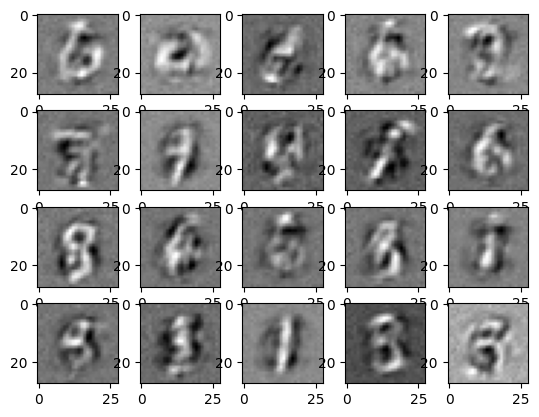

In [ ]:
fig, axs = plt.subplots(4, 5)

idx = 0
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(generated_img.cpu()[idx].detach(), cmap= 'grey')
        idx += 1

# *DCGAN*

In [ ]:
class Generator(nn.Module):
    """
    Generator Model: Uses Conv nets instead of FCN
    """

    def __init__(self, noise_dim: int = 100 )-> None:
        super().__init__()

        # layer 1. just a linear projection
        self.l1 = nn.Linear(noise_dim, 4 * 4 * 1024, bias = False)

        # layer 2
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, 2, padding = 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # (B, 512, 8, 8)

        # layer 3
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # (B, 256, 16, 16)

        # layer 4
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # (B, 128, 32, 32)

        # final layer
        self.tconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 5, 2, padding= 2, output_padding= 1, bias = False) ,
            nn.Tanh()
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Model parameters : {(self._get_parameters_count()) / 1e+6:2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        out = self.tconv4(self.tconv3(self.tconv2(self.tconv1(self.l1(x).reshape(-1, 4, 4, 1024).permute(0, 3, 1, 2)))))
        return out

class Discriminator(nn.Module):

    """
    Discriminator Model: Uses Conv nets instead of FCN for classifies image as Fake/Real
    """

    def __init__(self, out_features = 1)-> None:
        super().__init__()

        # layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, padding= 2),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, padding= 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 5, 2, padding= 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 5, 2, padding= 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # final laeyr
        self.final = nn.Sequential(
            nn.Flatten(start_dim= 1),
            nn.Linear(512 * 4 * 4, out_features),
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {(self._get_parameters_count())/1e+6:2f}M")

    def _get_parameters_count(self) -> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def _init_weights(self, m)-> None:
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)


    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Output of Generator Network

        Returns:
            out (torch.Tensor): Scaler Tensor does the image is Real/Fake value B/W 0-1

        """
        out = self.final(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        return out

In [ ]:
noise_dim = 100
batch_size = 64

# Hyperparameters
epochs = 2                    # Number of steps we what to train our model
lr = 0.0002                     # learning step size
weight_decay: float = 1e-1     # weight decay
k = 1                          # How many steps do we want to train discriminator

In [ ]:
G = Generator(noise_dim).to(device)
torch.compile(G)
# Discriminator Network
D = Discriminator().to(device)
torch.compile(D)

print("Models are compiled")

Generator Model parameters : 18.852992M
Discriminator Network parameters : 4.316545M
Models are compiled


In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Generator optimizer
opt_G = optim.AdamW(G.parameters(), lr = lr, betas=(0.5, 0.999))
# Discriminator optimier
opt_D = optim.AdamW(D.parameters(), lr = lr, weight_decay = weight_decay, betas=(0.5, 0.999))

In [ ]:
# loads training data efficiently
mnist_dataloader = DataLoader(mnist_dataset,
                              batch_size= batch_size,
                              shuffle= True,
                              pin_memory= True,
                              drop_last= True,
                              num_workers= os.cpu_count() - 1)

In [ ]:
d_lossi = []
g_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 2 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    for batch, (real_imgs, _) in enumerate(mnist_dataloader, 0):
        real_imgs = real_imgs.to(device, non_blocking = True)

        for _ in range(k):

            # ---------------------
            # A.Train Discriminator
            # ---------------------
            G.requires_grad_(False)
            D.requires_grad_(True)
            opt_D.zero_grad()

            noise = torch.rand(batch_size, noise_dim, device = device) * 2 - 1
            real_labels = torch.ones(batch_size, 1, device = device)
            fake_labels = torch.zeros(batch_size, 1, device = device)

            with torch.autocast(device_type= device, dtype= torch.bfloat16):

                # Real Images
                pred_real = D(real_imgs)
                loss_real = criterion(pred_real, real_labels)

                # Fake Images
                fake_imgs = G(noise).detach()     # make sure we don't train G when traning D
                pred_fake = D(fake_imgs)
                loss_fake = criterion(pred_fake, fake_labels)

            # back-prop and update D parameters
            loss_D = (loss_real + loss_fake) #* 0.5
            loss_D.backward()
            opt_D.step()

            d_lossi.append(loss_D.item())

        # B.Train Generator
        G.requires_grad_(True)
        D.requires_grad_(False)
        opt_G.zero_grad()

        noise = torch.rand((batch_size, noise_dim), device = device) * 2 - 1
        target_labels = torch.ones(batch_size, 1, device = device)

        with torch.autocast(device_type= device, dtype= torch.bfloat16):
            generated = G(noise)
            # fool the D to think it's reciving real images
            pred = D(generated)
            loss_G = criterion(pred, target_labels)

        # back-prop and update G parameters
        loss_G.backward()
        opt_G.step()

        g_lossi.append(loss_G.item())

        if (epoch % 2 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == mnist_dataloader.__len__() - 1):
            print(f"{mnist_dataloader.__len__()}/{batch}: D: loss_real {loss_real}, loss_fake {loss_fake} G: loss {loss_G}")

end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

Epoch 1
937/0: D: loss_real 0.7054636478424072, loss_fake 1.1072477102279663 G: loss 30.087890625
937/200: D: loss_real 1.4149525165557861, loss_fake 0.21408110857009888 G: loss 0.47472575306892395
937/400: D: loss_real 0.46308469772338867, loss_fake 0.769797146320343 G: loss 1.6290467977523804
937/600: D: loss_real 0.4591602087020874, loss_fake 1.0063339471817017 G: loss 1.5850322246551514
937/800: D: loss_real 0.5104845762252808, loss_fake 0.7685343027114868 G: loss 1.0951465368270874
937/936: D: loss_real 0.6614255309104919, loss_fake 0.47805967926979065 G: loss 1.1832666397094727
Epoch 2
937/0: D: loss_real 0.47443634271621704, loss_fake 0.4978708028793335 G: loss 1.1666550636291504
937/200: D: loss_real 1.2269010543823242, loss_fake 0.21672476828098297 G: loss 0.32864072918891907
937/400: D: loss_real 0.4838777184486389, loss_fake 0.5079717040061951 G: loss 1.069463849067688
937/600: D: loss_real 0.5485948324203491, loss_fake 0.7780768871307373 G: loss 1.2270623445510864
937/800: 

In [ ]:
# sampling from GAN
G.eval()
noise = torch.rand((20, noise_dim), device= device) * 2 - 1
generated_img = G(noise)

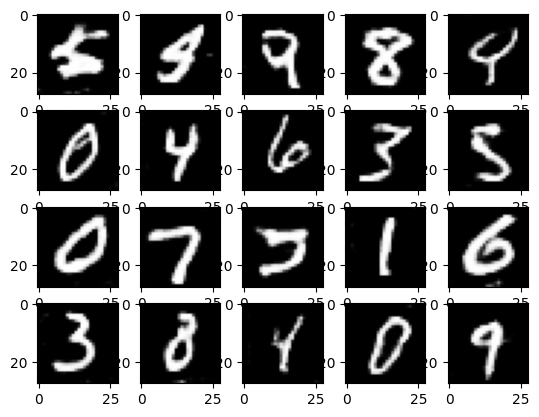

In [ ]:
# plot the sampled images
fig, axs = plt.subplots(10, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.0, left=0.3220)

idx = 0
for i in range(10):
    for j in range(10):
        axs[i, j].axis("off")
        axs[i, j].imshow(generated_img.cpu().permute(0, 2, 3, 1)[idx].detach(), cmap= 'grey')
        idx += 1

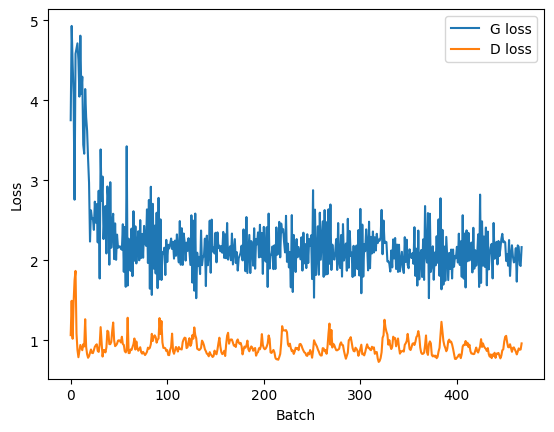

In [ ]:
# visualizing G and D loss
plt.plot(torch.tensor(g_lossi).view(10, -1).mean(0).tolist())
plt.plot(torch.tensor(d_lossi).view(10, -1).mean(0).tolist())
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.legend(['G loss', "D loss"])
plt.show()

# *WGAN*

*Wasserstein Generative Adversarial Networks- WGAN:*

    1. uses w-loss instead of BCE
    2. w-loss gives real number scores instead 0 (fake) or 1 (real)
    3. That's why Discriminator called as Critic
NOTE:

when training gan that uses critic instead of discriminator will give loss as scores so it not actually loss it's scores that critic gives to images. so it ranges vary in real values. so what we expect is when training gan that is critic based , the loss (scores) of discriminator will go small number like very negative , but generator scores will increase that will go too positive . this is good covergence for critic based gan

In [ ]:
class Generator(nn.Module):
    """
    Generator Model: Uses Conv nets instead of FCN
    """

    def __init__(self, noise_dim: int = 100 )-> None:
        super().__init__()

        # layer 1. just a linear projection
        self.l1 = nn.Linear(noise_dim, 4 * 4 * 1024, bias = False)

        # layer 2
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, 2, padding = 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # (B, 512, 8, 8)

        # layer 3
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # (B, 256, 16, 16)

        # layer 4
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # (B, 128, 32, 32)

        # final layer
        self.tconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 5, 2, padding= 2, output_padding= 1, bias = False) ,
            nn.Tanh()
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Model parameters : {(self._get_parameters_count()) / 1e+6:2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        out = self.tconv4(self.tconv3(self.tconv2(self.tconv1(self.l1(x).reshape(-1, 4, 4, 1024).permute(0, 3, 1, 2)))))
        return out

class Discriminator(nn.Module):

    """
    Discriminator Model: Uses Conv nets instead of FCN for classifies image as Fake/Real
    """

    def __init__(self, out_features = 1)-> None:
        super().__init__()

        # layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, padding= 2),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, padding= 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 5, 2, padding= 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 5, 2, padding= 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # final laeyr
        self.final = nn.Sequential(
            nn.Flatten(start_dim= 1),
            nn.Linear(512 * 4 * 4, out_features),
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {(self._get_parameters_count())/1e+6:2f}M")

    def _get_parameters_count(self) -> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def _init_weights(self, m)-> None:
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)


    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Output of Generator Network

        Returns:
            out (torch.Tensor): Scaler Tensor does the image is Real/Fake value B/W 0-1

        """
        out = self.final(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        return out

In [ ]:
noise_dim = 100
batch_size = 64

# Hyperparameters
epochs = 10                    # Number of steps we what to train our model
lr = 5e-5                      # learning step size
weight_decay: float = 1e-1     # weight decay
n_critic = 5                   # How many steps do we want to train Critic
c = 0.01                       # weight cliping

In [ ]:
G = Generator(noise_dim).to(device)
torch.compile(G)
# Discriminator Network
C = Critic().to(device)
torch.compile(C)

print("Models are compiled")

In [ ]:
# RMSprop optimizer
rmsopt_G  = optim.RMSprop(G.parameters(), lr= lr,)
rmsopt_C = optim.RMSprop(C.parameters(), lr = lr, weight_decay= weight_decay)

In [ ]:
# Dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle= True, pin_memory= True, drop_last= True)

In [ ]:
c_lossi = []
g_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 2 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    for batch, (real_imgs, _) in enumerate(train_dataloader, 0):
        real_imgs = real_imgs.to(device, non_blocking = True)

        for _ in range(n_critic):

            # A.Train Discriminator
            G.requires_grad_(False)
            C.requires_grad_(True)
            rmsopt_C.zero_grad()


            # noise-z
            noise = torch.randn(batch_size, noise_dim, device = device)

            # Real Image Batch
            pred_real = C(real_imgs)

            # Fake Image Batch
            fake_imgs = G(noise).detach()     # make sure we don't train G when traning D
            pred_fake = C(fake_imgs)

            # critic loss
            loss_C = -1 * pred_real.mean() + pred_fake.mean()

            # Back-prop & update Critic parameters
            loss_C.backward()
            rmsopt_C.step()

            # weight clip for Critic to enforce 1-L continuty
            with torch.no_grad():
                for p in C.parameters():
                    p.data.clamp(-c, c)

            c_lossi.append(loss_C.item())

        # B.Train Generator
        G.requires_grad_(True)
        C.requires_grad_(False)
        rmsopt_G.zero_grad()

        noise = torch.randn((batch_size, noise_dim), device = device)

        generated = G(noise)
        pred = C(generated)
        loss_G = -1 * pred.mean()

        # back-prop and update G parameters
        loss_G.backward()
        rmsopt_G.step()

        g_lossi.append(loss_G.item())

        if (epoch % 2 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == train_dataloader.__len__()-1):
            print(f"{train_dataloader.__len__()}/{batch}: C: loss {loss_C} G: loss {loss_G}")

end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

Epoch 1
937/0: C: loss -32.62131118774414 G: loss 13.47209644317627
937/200: C: loss -324.8592834472656 G: loss 164.71987915039062
937/400: C: loss -371.93609619140625 G: loss 129.61648559570312
937/600: C: loss -745.440185546875 G: loss 375.7406005859375
937/800: C: loss -1007.3125 G: loss 479.0196838378906
937/936: C: loss -1091.19287109375 G: loss 452.400634765625
Epoch 3
937/0: C: loss -2950.03369140625 G: loss 1387.40185546875
937/200: C: loss -3334.146728515625 G: loss 1609.212158203125
937/400: C: loss -3653.534912109375 G: loss 1409.580810546875
937/600: C: loss -4643.427734375 G: loss 2513.8486328125
937/800: C: loss -4826.826171875 G: loss 2399.09228515625
937/936: C: loss -4960.70556640625 G: loss 2278.820556640625
Epoch 5
937/0: C: loss -8847.2421875 G: loss 4570.39697265625
937/200: C: loss -9185.8203125 G: loss 4773.5634765625
937/400: C: loss -10442.287109375 G: loss 5639.0009765625
937/600: C: loss -10854.9931640625 G: loss 4920.619140625
937/800: C: loss -11989.9316406

In [ ]:
# sampling from generator
G.eval()

noise = torch.randn((100, noise_dim), device = device)
generated_img = G(noise)

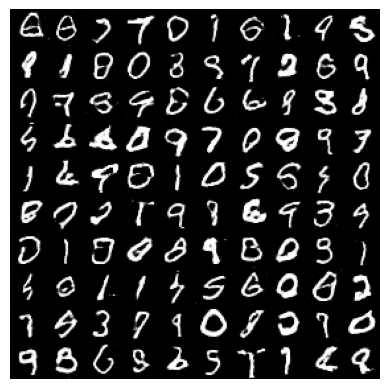

In [ ]:
# plot the sampled images
fig, axs = plt.subplots(10, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.0, left=0.3220)

idx = 0
for i in range(10):
    for j in range(10):
        axs[i, j].axis("off")
        axs[i, j].imshow(generated_img.cpu().permute(0, 2, 3, 1)[idx].detach(), cmap= 'grey')
        idx += 1


#*WGAN-GP*

In [ ]:
class Generator(nn.Module):
    """
    Generator Model: Uses Conv nets instead of FCN
    """

    def __init__(self, noise_dim: int = 100 )-> None:
        super().__init__()

        # layer 1. just a linear projection
        self.l1 = nn.Linear(noise_dim, 4 * 4 * 1024, bias = False)

        # layer 2
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, 2, padding = 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # (B, 512, 8, 8)

        # layer 3
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # (B, 256, 16, 16)

        # layer 4
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, padding= 2, output_padding= 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # (B, 128, 32, 32)

        # final layer
        self.tconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 5, 2, padding= 2, output_padding= 1, bias = False) ,
            nn.Tanh()
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Model parameters : {(self._get_parameters_count()) / 1e+6:2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        out = self.tconv4(self.tconv3(self.tconv2(self.tconv1(self.l1(x).reshape(-1, 4, 4, 1024).permute(0, 3, 1, 2)))))
        return out

class Discriminator(nn.Module):

    """
    Discriminator Model: Uses Conv nets instead of FCN for classifies image as Fake/Real
    """

    def __init__(self, out_features = 1)-> None:
        super().__init__()

        # layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, padding= 2),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, padding= 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 5, 2, padding= 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # layer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 5, 2, padding= 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        # final laeyr
        self.final = nn.Sequential(
            nn.Flatten(start_dim= 1),
            nn.Linear(512 * 4 * 4, out_features),
        )

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {(self._get_parameters_count())/1e+6:2f}M")

    def _get_parameters_count(self) -> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def _init_weights(self, m)-> None:
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)


    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Output of Generator Network

        Returns:
            out (torch.Tensor): Scaler Tensor does the image is Real/Fake value B/W 0-1

        """
        out = self.final(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        return out

def compute_gradient_penalty(C: nn.Module,
                             real_imgs: torch.Tensor,
                             fake_imgs: torch.Tensor,
                             lamda: int) -> torch.Tensor:
    """
    Computes gradient penalty w.r.t interpolated image. lamda(l2_norm(x_hat_grad(C(x_hat)) - 1)**2)

    Args:
        C (nn.Module): Critic model that takes Fake/Interpolated Image and gives scores
        real_imgs (torch.Tensor): Real Images from dataset
        fake_imgs (torch.Tensor): Fake Images from Generator model
        lamda (torch.Tensor): Co-efficient term for penalty

    Returns:
        gradient_penalty (torch.Tensor): Scalar gradient penalty

    """

    # random number drawn from uniform distripution
    eps = torch.rand((batch_size, 1, 1, 1), device = real_imgs.device)
    # interpolated images
    x_hat = eps * real_imgs + (1 - eps) * fake_imgs
    x_hat.requires_grad_(True)
    # Discriminator's (i mean Critic) score on interpolated images
    critic_score = C(x_hat)

    # compute gradients w.r.t x_hat
    gradients = torch.autograd.grad(
        critic_score,
        x_hat,
        torch.ones_like(critic_score),
        retain_graph = True,
        create_graph = True
    )[0] # (batch, channels, height, weight)

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = lamda * ((gradients.norm(2, dim = 1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
noise_dim: int = 100
batch_size: int = 64

# Hyperparameters
epochs: int = 10                    # Number of steps we what to train our model
lr: float = 1e-4                    # learning step size
weight_decay: float = 1e-1          # weight decay
n_critic: int = 5                   # How many steps do we want to train Critic
lamda: int = 10                     # co-efficint in gradient penalty
betas: tuple = (0.0, 0.9)           # Adam's momentums

In [ ]:
G = Generator(noise_dim).to(device)
torch.compile(G)
# Discriminator Network
C = Critic().to(device)
torch.compile(C)

print("Models are compiled")

In [ ]:
# Adam optimizer for Generator and Critic
opt_G = optim.Adam(G.parameters(), lr = lr, betas= betas)
opt_C = optim.Adam(C.parameters(), lr = lr, betas = betas)

In [ ]:
# Dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle= True, pin_memory= True, drop_last= True)

In [ ]:
c_lossi = []
g_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 2 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    for batch, (real_imgs, _) in enumerate(train_dataloader, 0):
        real_imgs = real_imgs.to(device, non_blocking = True)

        for _ in range(n_critic):

            # ---------------------
            # A.Train Critic
            # ---------------------

            G.requires_grad_(False)
            C.requires_grad_(True)
            opt_C.zero_grad()

            # z-noise
            noise = torch.randn(batch_size, noise_dim, device = device)

            # Real Image Batch
            real_imgs = real_imgs
            pred_real = C(real_imgs)

            # Fake Image Batch
            fake_imgs = G(noise).detach()     # make sure we don't train G when traning D
            pred_fake = C(fake_imgs)

            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(C, real_imgs, fake_imgs, lamda)

            # critic loss
            loss_C = -1 * pred_real.mean() + pred_fake.mean() + gradient_penalty

            # Back-prop & update Critic parameters
            loss_C.backward()
            opt_C.step()

            c_lossi.append(loss_C.item())

        # -----------------
        # B.Train Generator
        # -----------------

        G.requires_grad_(True)
        C.requires_grad_(False)
        opt_G.zero_grad()

        noise = torch.randn((batch_size, noise_dim), device = device)
        generated = G(noise)
        pred = C(generated)
        loss_G = -1 * pred.mean()

        # back-prop and update G parameters
        loss_G.backward()
        opt_G.step()

        g_lossi.append(loss_G.item())

        if (epoch % 2 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == train_dataloader.__len__()-1):
            print(f"{train_dataloader.__len__()}/{batch}: C: loss {loss_C} G: loss {loss_G}")

end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

Epoch 1
937/0: C: loss -3.927161455154419 G: loss 2.2124993801116943
937/200: C: loss -26.964038848876953 G: loss 11.231924057006836
937/400: C: loss -114.89473724365234 G: loss 14.070840835571289
937/600: C: loss -267.7690734863281 G: loss 67.60874938964844
937/800: C: loss -464.5199279785156 G: loss 113.43352508544922
937/936: C: loss -492.57513427734375 G: loss 114.32847595214844
Epoch 3
937/0: C: loss -1911.6810302734375 G: loss 744.936279296875
937/200: C: loss -2077.19873046875 G: loss 412.0137023925781
937/400: C: loss -2286.313232421875 G: loss 801.0008544921875
937/600: C: loss -1967.921630859375 G: loss -344.25390625
937/800: C: loss -2031.6845703125 G: loss 268.92169189453125
937/936: C: loss -1937.84765625 G: loss 289.2513427734375
Epoch 5
937/0: C: loss -4291.771484375 G: loss -459.7718200683594
937/200: C: loss -4585.1484375 G: loss 2138.6103515625
937/400: C: loss -5013.5966796875 G: loss 1771.7398681640625
937/600: C: loss -5471.58251953125 G: loss 2643.9541015625
937/8

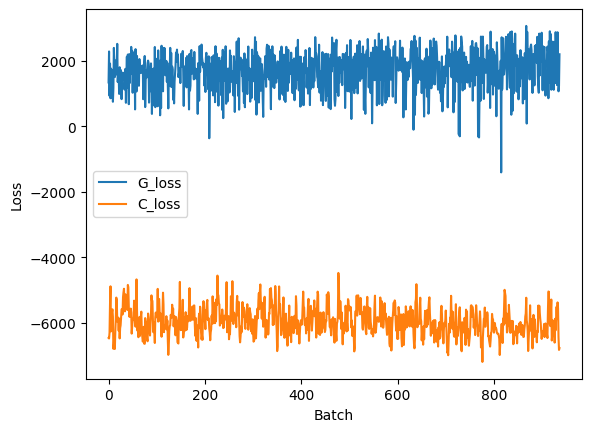

In [ ]:
plt.plot(torch.tensor(g_lossi).view(10, -1).mean(0))
plt.plot(torch.tensor(c_lossi).view(50, -1).mean(0))
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.legend(['G_loss', "C_loss"])
plt.show()

In [ ]:
# torch.save(opt_G.state_dict(), "/content/optim_g_wgan-gp")
# torch.save(opt_C.state_dict(), "/content/optim_c_wgan-gp")

In [ ]:
# torch.save(G.state_dict(), "/content/g_wgangp_weight")
# torch.save(C.state_dict(), "/content/c_wgangp_weight")

In [ ]:
# sampling from generator
G.eval()

noise = torch.randn((100, noise_dim), device = device)
generated_img = G(noise)

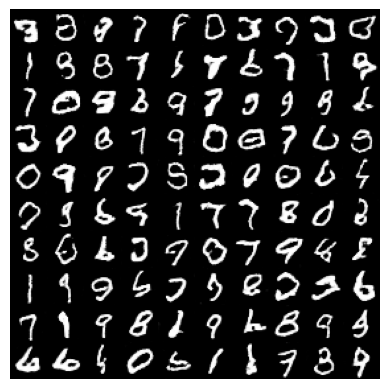

In [ ]:
# plot the sampled images
fig, axs = plt.subplots(10, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.0, left=0.3220)

idx = 0
for i in range(10):
    for j in range(10):
        axs[i, j].axis("off")
        axs[i, j].imshow(generated_img.cpu().permute(0, 2, 3, 1)[idx].detach(), cmap= 'grey')
        idx += 1

# *TGAN*

In [ ]:
!echo Downloading pre-trained weights
!gdown https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I

Downloading...
From (original): https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I
From (redirected): https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I&confirm=t&uuid=b38e761d-fd0b-48e8-9256-3190eefa03de
To: /content/state_normal81000.ckpt
100% 124M/124M [00:02<00:00, 41.4MB/s]


In [ ]:
class CustomNormalizer(nn.Module):
    """
    CustomNormalizer to normalize image pixels to within range of (-1, 1) according to paper.
    cause we are using tanh in Generator Model at last layer
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T, C, H, W = x.shape       # (channels, height, width)

        # if grey scale image then we have to make it have 3 pixels
        if C < 3:
            x = torch.repeat_interleave(x, dim = 1, repeats = 3)

        x = (x / 255) * 2 - 1      # normalizer to (-1, 1) range
        return x.transpose(0, 1)   # (C, T, H, W)


# pipeline
transform = v2.Compose([
    v2.ToDtype(dtype= torch.float32),
    CustomNormalizer(),
])

# Dataset
mminst_root =  "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy"
mminst_dataset = torchvision.datasets.MovingMNIST(mminst_root, download= True, transform= transform)

# Dataloader
dataloader = DataLoader(mminst_dataset, batch_size= batch_size, shuffle = True, pin_memory = True, drop_last = True)

In [ ]:
# Helper fn for visualizing videos
def make_video_grid(videos: list,
                    grid_size: tuple =(4, 4),
                    resize: tuple = (64, 64),
                    fps: int = 10,
                    filename: str = "grid_video.mp4"):
    """
    videos: list of tensors, each [T, C, H, W] in [0, 1] if not we have to clamp
    grid_size: (rows, cols)
    resize: (new_height, new_width) of each video in grid
    """
    assert len(videos) == grid_size[0] * grid_size[1], "Grid size doesn't match number of videos"

    # make sure all videos are in good shape
    T, C, H, W = videos[0].shape
    for v in videos:
        assert v.shape == (T, C, H, W)

    video_np_list = []
    for v in videos:
        v = torch.clamp(v, 0, 1)
        np_clip = (v.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
        # Ensure 3-channel: if grayscale (C=1), duplicate across channels
        if np_clip.shape[-1] == 1:
            np_clip = np.repeat(np_clip, 3, axis=-1)
        video_np_list.append(np_clip)

    grid_frames = []
    for t in range(T):
        row_frames = []
        for i in range(grid_size[0]):
            row = []
            for j in range(grid_size[1]):
                idx = i * grid_size[1] + j
                frame = video_np_list[idx][t]  # [H, W, C]
                resized_frame = cv2.resize(frame, (resize[1], resize[0]))  # resize(W, H)
                row.append(resized_frame)
            row_frames.append(np.concatenate(row, axis=1))  # horizontal concat
        grid_frame = np.concatenate(row_frames, axis=0)  # vertical concat
        grid_frames.append(grid_frame)

    clip = ImageSequenceClip(grid_frames, fps=fps)
    clip.write_videofile(filename, fps=fps, codec="libx264", audio=False)

    return Video(filename, embed=True)

In [ ]:
# visualizing videos as grid of videos

videos = []
for i in range(36):
    videos.append(video_batch[i])

make_video_grid(
    videos,
    grid_size=(6, 6),
    resize=(64, 64),  # <-- upscale each video
    fps= 10,
    filename="grid_resized.mp4"
)

In [ ]:
class TemporalGenerator(nn.Module):
    """
    TemporalGenerator:
        For given noise generates latent temporal (time) features
    """
    def __init__(self):
        super().__init__()
        # Create a sequential model to turn one vector into 16
        self.model = nn.Sequential(
            nn.ConvTranspose1d(100, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 100, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        # initialize weights according to paper
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose1d:
            nn.init.xavier_uniform_(m.weight, gain=2**0.5)

    def forward(self, x):
        # reshape x so that it can have convolutions done
        x = x.view(-1, 100, 1)
        # apply the model and flip the
        x = self.model(x).transpose(1, 2)
        return x


class VideoGenerator(nn.Module):
    """
    VideoGenerator:
        Generated Images from given latent temporal features
    """

    def __init__(self):
        super().__init__()
        # instantiate the temporal generator
        self.temp = TemporalGenerator()

        # create a transformation for the temporal vectors
        self.fast = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        # create a transformation for the content vector
        self.slow = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )


        # define the image generator
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # initialize weights according to the paper
        self.fast.apply(self.init_weights)
        self.slow.apply(self.init_weights)
        self.model.apply(self.init_weights)

        print(f"{self.__class__.__name__} parameters: {(self._get_parameters_count() / 1e+6):.2f} M")

    def _get_parameters_count(self)-> int:
        """
        Returns total parameters in model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def device(self)-> torch.DeviceObjType:
        return next(self.parameters()).device

    def init_weights(self, m)-> None:
        if type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-0.01, b=0.01)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Takes noise Generates video

        Args:
            x (torch.Tensor) : prior lantent noise vector randomly drawn. Shape (B, 100)

        Returns:
            out (torch.Tensor): Generated Videos with Shape (B, T, C, H, W) -> (batch_size, (time)frames, channels, height, width)
        """

        # pass our latent vector through the temporal generator and reshape
        z_fast = self.temp(x).contiguous()       # (B, T, 100)
        z_fast = z_fast.view(-1, 100)            # (B*T, 100)

        # transform (just a linear projection) the content and temporal vectors
        z_fast = self.fast(z_fast).view(-1, 256, 4, 4)                      # (B*T, C, H, W)
        z_slow = self.slow(x).view(-1, 256, 4, 4).unsqueeze(1)              # (B, 1, C, H, W)

        # after z_slow is transformed and expanded we can duplicate it
        z_slow = torch.cat([z_slow]*16, dim=1).view(-1, 256, 4, 4)          # (B*T, C, H, W)

        # concatenate the temporal and content vectors
        z = torch.cat([z_slow, z_fast], dim=1)                              # (B*T, C + C, H, W)

        # transform into image frames
        out = self.model(z)

        return out.view(-1, 16, 3, 64, 64).transpose(1, 2)             # reshape and transpose (B, C, T, H, W)


class VideoCritic(nn.Module):
    """

    VideoCritic:
        VideoCritic scores weather the video came from real/fake distribution

    """

    def __init__(self):
        super().__init__()

        self.model3d = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            nn.Conv3d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )

        self.conv2d = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        # initialize weights according to paper
        self.model3d.apply(self.init_weights)
        self.init_weights(self.conv2d)

        # report parameters
        print(f"{self.__class__.__name__} parameters: {(self._get_parameters_count() / 1e+6):.2f} M")

    def _get_parameters_count(self)-> int:
        """
        Returns total parameters in model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def device(self)-> torch.DeviceObjType:
        return next(self.parameters()).device

    def init_weights(self, m):
        if type(m) == nn.Conv3d or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight, gain=2**0.5)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Videos from Real/Fake dist with shape (B, C, T, H, W)

        Returns:
            h (torch.Tensor): scores with shape (B, ) weather a vedio is from real/fake distribution
        """

        h = self.model3d(x)
        # turn a tensor of R^NxCxTxHxW into R^NxCxHxW
        h = torch.reshape(h, (32, 512, 4, 4))        # (B, C, H, W)
        h = self.conv2d(h).view(-1)                  # (B, 1, 1, 1) -> (B)
        return h

def singular_value_clip(weight: torch.Tensor):
    """
    Singular Value Decomposition clip for conv, linear weights
    """
    dim = weight.shape
    # reshape into matrix if not already MxN
    if len(dim) > 2:
        w = weight.reshape(dim[0], -1)
    u, s, v = torch.svd(w, some=True)
    s[s > 1] = 1
    return (u @ torch.diag(s) @ v.t()).view(dim)

def batchnorm_gamma_clip(module: nn.Module):
    """
    cliping batchnorm's learnable parameter gamma within range of  0 < gamma <= sqrt(running_var)
    """
    gamma = module.weight.data
    std = torch.sqrt(module.running_var)
    gamma[gamma > std] = std[gamma > std]
    gamma[gamma < 0.01 * std] = 0.01 * std[gamma < 0.01 * std]
    return gamma

In [ ]:
noise_dim = 100

# Hyperparameters
epochs = 2                     # Number of steps we what to train our model
lr = 5e-5                      # learning step size
weight_decay: float = 1e-1     # weight decay
n_critic = 5                   # How many steps do we want to train Critic

In [ ]:
# initiating models
VG = VideoGenerator().to(device)
torch.compile(VG)
VC = VideoCritic().to(device)
torch.compile(VC)

print("Models are compiled !")

VideoGenerator parameters: 4.45 M
VideoCritic parameters: 11.03 M
Models are compiled !


In [ ]:
# Video Generator optimizer
ropt_VG = optim.RMSprop(VG.parameters(), lr = lr)
# Video Critic optimizer
ropt_VC = optim.RMSprop(VC.parameters(), lr = lr, weight_decay= weight_decay)

In [ ]:
vc_lossi = []
vg_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 2 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    for current_batch, real_videos in enumerate(dataloader, 0): # videos with shape (B, T, C, H, W)
        real_vids = real_videos.to(device, non_blocking = True)

        for _ in range(n_critic):

            # -----------------
            # A.Training Critic
            # ------------------
            VG.requires_grad_(False)
            VC.requires_grad_(True)
            ropt_VC.zero_grad()

            # z-noise
            noise = torch.rand((batch_size, noise_dim), device = device) * 2 - 1

            # Real Image Batch
            pred_real = VC(real_vids)

            # Fake Image Batch
            fake_vids = VG(noise).detach()     # make sure we don't train VG when traning VC
            pred_fake = VC(fake_vids)

            # critic loss
            loss_VC = -pred_real.mean() + pred_fake.mean()

            # Back-prop & update Critic parameters
            loss_VC.backward()
            ropt_VC.step()

            vc_lossi.append(loss_VC.item())

        # ---------------------
        # B.Train VideoGenerator
        # ----------------------
        VG.requires_grad_(True)
        VC.requires_grad_(False)
        ropt_VG.zero_grad()

        noise = torch.rand((batch_size, noise_dim), device = device) * 2 - 1
        generated = VG(noise)
        pred = VC(generated)
        loss_VG = -1 * pred.mean()

        # back-prop and update G parameters
        loss_VG.backward()
        ropt_VG.step()

        vg_lossi.append(loss_VG.item())

        # 1-L enforce for only Discriminator (i mean Critic)
        if current_batch + 1 % 5 == 0:
            for module in list(VC.model3d.children()) + [VC.conv2d]:
                if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d):
                    module.weight.data = singular_value_clip(module.weight)
                elif isinstance(module, nn.BatchNorm3d):
                    module.weight.data = batchnorm_gamma_clip(module)

        if (epoch % 2 == 0 or epoch == epochs - 1) and ( current_batch % 50 == 0 or current_batch == dataloader.__len__()-1):
            print(f"{dataloader.__len__()}/{current_batch}: VC: loss {loss_VC} VG: loss {loss_VG}")

end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

Epoch 1
312/0: VC: loss -156.97622680664062 VG: loss 86.5619125366211
312/50: VC: loss -340.3760681152344 VG: loss 162.68310546875
312/100: VC: loss -470.4463195800781 VG: loss 225.96580505371094
312/150: VC: loss -602.4815673828125 VG: loss 291.5386962890625
312/200: VC: loss -741.4029541015625 VG: loss 360.7975769042969
312/250: VC: loss -888.6416015625 VG: loss 434.00079345703125
312/300: VC: loss -1039.080810546875 VG: loss 508.2623291015625
312/311: VC: loss -1071.2530517578125 VG: loss 524.276123046875
Epoch 2
312/0: VC: loss -1075.80322265625 VG: loss 526.5555419921875
312/50: VC: loss -1233.2606201171875 VG: loss 603.9368896484375
312/100: VC: loss -1396.4088134765625 VG: loss 685.078125
312/150: VC: loss -1565.4129638671875 VG: loss 767.8278198242188
312/200: VC: loss -1740.2784423828125 VG: loss 853.3148193359375
312/250: VC: loss -1924.9788818359375 VG: loss 945.37353515625
312/300: VC: loss -2108.335205078125 VG: loss 1036.303955078125
312/311: VC: loss -2150.731201171875 V

In [ ]:
def genSamples(g, n=6):
    '''
    Generate an n by n grid of videos, given a generator g
    '''
    with torch.no_grad():
        s = g(torch.rand((n**2, 100), device='cuda')*2-1).cpu().detach().numpy()

    out = np.zeros((3, 16, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n+k, :, :, :, :]


    out = out.transpose((1, 2, 3, 0))
    out = (out + 1) / 2 * 255
    out = out.astype(int)

    clip = ImageSequenceClip(list(out), fps= 10)
    clip.write_videofile("sample.mp4", fps= 10, codec="libx264", audio=False)

In [ ]:
# pretrained weights
VG.load_state_dict(torch.load('state_normal81000.ckpt')['model_state_dict'][0])

<All keys matched successfully>

In [ ]:
genSamples(VG, n = 6)

Moviepy - Building video sample.mp4.
Moviepy - Writing video sample.mp4



Moviepy - Done !
Moviepy - video ready sample.mp4


In [ ]:
Video("sample.mp4", embed= True)